# Efficiently Selecting and Processing Raster and Vector Data

This workflow introduces how to search for, acquire and process raster data efficiently. Specfically, we demonstrate finding [Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2) satellite imagery relevant for an area and time, in this case, a time range of a few months (during the Kharif season) in 2020 over a subdistrict in India.

Note: some portions of this notebook are inspired by the [Introduction to Geospatial Raster and Vector Data with Python course](https://carpentries-incubator.github.io/geospatial-python/index.html).


## Main Objectives

- **Access Sentinel-2 data**: Locate and retrieve relevant Sentinel-2 data for a specific area and timeframe via STAC.
- **Inspect and visualize raster data**: Examine metadata, including projections, bands, dimensions, no data pixels. Plot raster data correctly.
- **Process multi-spectral raster data**: Work with vector data to establish bounds, manage coordinate systems, and set up the area of interest (AOI).
- **Interpret time-series raster data**: Learn to explore the time dimension for raster data and search for temporal patterns.
- **Cloud and nodata masking**: Handle clouds and no data pixels.
- **Compositing**: Create composites from multiple image scenes.
- **Speed up raster processing with Dask**: Learn how to optimize raster processing steps using a parallel processing library.
- **Raster band math**: Calculate relevant spectral indices using Sentinel-2 data.
- **Scalably visualize vector data with Lonboard**: Load a field boundaries with 10000 polygons and visualize it with Lonboard.
- **Calculate zonal statistics with the field boundaries**: Show how to calculate zonal statistics for a spectral index.


At the end, you'll be able to efficiently process raster imagery for a region and time of interest!

Let's begin by importing our necessary packages.

In [99]:
import dask
import geopandas as gpd
import odc.stac
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pystac_client
import rasterio
import requests
import rioxarray
import time
import xarray as xr
from geocube.api.core import make_geocube
from geopandas import GeoSeries, GeoDataFrame
from lonboard import Map, PolygonLayer, viz
from pyproj import CRS
from rasterstats import zonal_stats
from shapely.geometry import box, Point, shape
from tqdm.auto import tqdm

## Accessing raster data

We'll select an area of interest by randomly sampling a subdistrict within India. This is what we will use to obtain geographic bounds required for selecting and acquiring raster data. 

Note that we set the coordinate reference system (CRS) to the projection that is used to load web map tiles and store coordinate metadata in the STAC catalog, `EPSG:4326 (WGS 84)`. 

In [4]:
# Read in the subdistricts boundaries dataset
subdistricts = gpd.read_file("./KA_subdistrict/KA_subdistrict.shp")
# Shuffle the dataset items
subdistricts.sample(frac=1)
# Select the first subdistrict
subdistrict = subdistricts.head(1).to_crs("EPSG:4326")
subdistrict

state           district       subdistric UID              RID  \
0  KARNATAKA  Bengaluru (Urban)  Bangalore-South  97  091017002000000   

                          layer  \
0  091017000000000_Subdistricts   

                                                path  \
0  C:/Users/SatSure-Chintan/Documents/Dev_Agri/aw...   

                                            geometry  
0  POLYGON ((77.51537 12.74491, 77.51444 12.74557...

Obtain a bounding box for the sampled subdistrict. This is for the image search query we will execute shortly.

In [5]:
bbox_coords = subdistrict.total_bounds 
bounding_box = box(*bbox_coords)

The area of interest can be seen in the following:

In [6]:
viz(subdistrict)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

Let’s dive into how to search for and retrieve raster data.

The [SpatioTemporal Asset Catalog (STAC)](https://stacspec.org/en) is an open standard created to standardize the organization and description of geospatial assets. It has come to serve a crucial role in the geospatial industry by providing a consistent framework and terminology for indexing and accessing Earth observation data along with relevant metadata. This specification allows for streamlined searching, browsing, and retrieval of geospatial information.

You can explore geospatial datasets using tools like the [STAC browser](https://radiantearth.github.io/stac-browser/#/?.language=en), which provides an up-to-date interface for navigating STAC catalogs. For instance, the ["Earth Search" catalog](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v1/?.language=en), which includes Sentinel-2 imagery [hosted on AWS](https://registry.opendata.aws/sentinel-2-l2a-cogs/), is a great starting point. 

To retrieve data from a catalog, locate its API URL in the STAC Browser by clicking the "Source" button in the top-right corner. This URL serves as a gateway to access and interact with the catalog's data. For the Earth Search catalog, the API URL would be displayed in this section, enabling you to programmatically access the archive.

In [7]:
# Access AWS STAC for Sentinel-2 Data
aws_stac_url = "https://earth-search.aws.element84.com/v1"

# You can query a STAC API endpoint from Python using the pystac_client library:
stac_client = pystac_client.Client.open(aws_stac_url)

In the upcoming steps, we will retrieve imagery from the Sentinel-2 L2A collection, which consists of data products processed to Level 2A. This processing level provides bottom-of-atmosphere (BOA) reflectance, making the data ready for analysis without additional atmospheric correction. 

The data is stored in the **Cloud Optimized GeoTIFF (COG)** format, a type of GeoTIFF specifically designed for efficient access in cloud environments. Unlike traditional GeoTIFFs, COGs are structured with internal data blocks that enable partial retrieval via HTTP requests, eliminating the need to download the entire file. Furthermore, they often include **overviews**, which are lower-resolution versions of the image. These overviews allow users to quickly access less detailed images when high resolution isn’t required, optimizing data transfer and reducing load times for online applications. For more about COGs, visit the [Cloud Optimized GeoTIFF website](http://cogeo.org/).

We parameterize our search for available Sentinel-2 scenes in the `sentinel-2-l2a` collection that meet the following criteria:
- intersect with a provided bounding box (boundaries of the area of interest);
- were captured between June 1, 2020, and November 30, 2020;
- have less than 25% cloud cover;
- have less than 25% invalid pixels.

In [14]:
s2_search = stac_client.search(
    collections=["sentinel-2-l2a"], # Sentinel-2, Level 2A, Cloud Optimized GeoTiffs (COGs)
    bbox=list(bbox_coords),
    datetime="2020-06-01/2020-11-30", 
    query={"eo:cloud_cover": {"lt": 25}, "s2:nodata_pixel_percentage": {"lt": 25}}, 
)

At this point, only metadata has been retrieved, meaning the actual image data has not yet been loaded into memory. However, it’s important to note that metadata alone can occupy significant memory, especially when the search criteria match a large number of images. To handle this efficiently, you can limit the number of search results by using the parameter `limit=n`, where `n` specifies the maximum number of items to return.

In [15]:
# Retrieve all items (still just metadata) from search results
s2_items = s2_search.item_collection()

After running the query to identify image scenes that match our search criteria, we can check the total number of matches using the `.matched()` method. Keep in mind that this number may change over time as new data continues to be added to the catalog.

In [16]:
print(s2_search.matched())

3


Which should equate to the number of items collected:

In [17]:
len(s2_items)

3

Each item corresponds to a single image scene, with metadata that includes details such as the scene's spatial geometry and the time it was captured. These details are accessible through the item's properties.


We can see an example for the first item in the search results:

In [18]:
item = s2_items[0]
print(item.datetime)
print(item.geometry)
print(item.properties)

2020-10-30 05:25:22.755000+00:00
{'type': 'Polygon', 'coordinates': [[[76.9264511632922, 13.561009631756564], [76.84512341593218, 13.195613356232856], [76.84054354907092, 12.569253669512213], [77.85045784138613, 12.560413606130458], [77.86185827663547, 13.552040522490456], [76.9264511632922, 13.561009631756564]]]}
{'created': '2023-07-14T17:27:10.917Z', 'platform': 'sentinel-2b', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 24.319877, 'proj:epsg': 32643, 'mgrs:utm_zone': 43, 'mgrs:latitude_band': 'P', 'mgrs:grid_square': 'GQ', 'grid:code': 'MGRS-43PGQ', 'view:sun_azimuth': 147.103568735944, 'view:sun_elevation': 58.0694452473349, 's2:degraded_msi_data_percentage': 0.0108, 's2:nodata_pixel_percentage': 1.396664, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 0.02103, 's2:cloud_shadow_percentage': 0.996768, 's2:vegetation_percentage': 53.468376, 's2:not_vegetated_percentage': 15.626453, 's2:water_percentage': 0.83676, 's2:unclassi

As noted earlier, only the metadata has been retrieved so far. Next, we will access the raster data, which consists of the image pixels for the selected scenes. In STAC terminology, these image files are referred to as "assets," with each band of an image represented by a separate asset. A straightforward way to load this image data is by using the URLs provided in the assets attribute of the corresponding item.

In [19]:
assets = s2_items[0].assets  # first item's asset dictionary
print(assets.keys())

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])


We can see a description of the available assets for the respective sensor/instrument like so:

In [20]:
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

aot: Aerosol optical thickness (AOT)
blue: Blue (band 2) - 10m
coastal: Coastal aerosol (band 1) - 60m
granule_metadata: None
green: Green (band 3) - 10m
nir: NIR 1 (band 8) - 10m
nir08: NIR 2 (band 8A) - 20m
nir09: NIR 3 (band 9) - 60m
red: Red (band 4) - 10m
rededge1: Red edge 1 (band 5) - 20m
rededge2: Red edge 2 (band 6) - 20m
rededge3: Red edge 3 (band 7) - 20m
scl: Scene classification map (SCL)
swir16: SWIR 1 (band 11) - 20m
swir22: SWIR 2 (band 12) - 20m
thumbnail: Thumbnail image
tileinfo_metadata: None
visual: True color image
wvp: Water vapour (WVP)
aot-jp2: Aerosol optical thickness (AOT)
blue-jp2: Blue (band 2) - 10m
coastal-jp2: Coastal aerosol (band 1) - 60m
green-jp2: Green (band 3) - 10m
nir-jp2: NIR 1 (band 8) - 10m
nir08-jp2: NIR 2 (band 8A) - 20m
nir09-jp2: NIR 3 (band 9) - 60m
red-jp2: Red (band 4) - 10m
rededge1-jp2: Red edge 1 (band 5) - 20m
rededge2-jp2: Red edge 2 (band 6) - 20m
rededge3-jp2: Red edge 3 (band 7) - 20m
scl-jp2: Scene classification map (SCL)
swi

The Sentinel-2 Level-2A data product offers a variety of assets, including raster files for each optical band captured by the multispectral instrument, a true-color thumbnail image ("visual"), metadata about the instrument, and scene classification layers ("SCL"). Let's retrieve the URLs associated with these assets to access the respective data.








In [21]:
print(assets["thumbnail"].href)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/43/P/GQ/2020/10/S2B_43PGQ_20201030_1_L2A/thumbnail.jpg


The URL points to the image's location in cloud storage. Since the raster data is stored remotely, we can utilize a library that enables direct access to the image without needing to download it to the local file system beforehand. This library is called `rioxarray`. 

In [22]:
nir_href = assets["nir"].href
nir = rioxarray.open_rasterio(nir_href)
print(nir)

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 7e+05 7e+05 7e+05 ... 8.097e+05 8.098e+05
  * y            (y) float64 88kB 1.5e+06 1.5e+06 1.5e+06 ... 1.39e+06 1.39e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0


Optionally, we can then save the raster data to a file on disk if needed:

In [23]:
# save whole image to disk
#nir.rio.to_raster("nir.tif")

Working with large rasters, such as the 10-meter NIR band containing over 100 million pixels, can be computationally intensive. To optimize processing, it's often practical to focus on a smaller subset of the data. With the Cloud Optimized GeoTIFF (COG) format, we can efficiently download just the required section instead of the entire file. Before doing so, let's examine the internal tile size of this band in the COG.

In [24]:
print(nir.shape)
tile_size = nir.rio._manager.acquire().block_shapes
tile_size

(1, 10980, 10980)


[(1024, 1024)]

In this case, we specify that we want to download the first band in the TIFF file and extract a subset by slicing the width and height dimensions.

In [25]:
# save portion of an image to disk
#nir[0,1024:2048,1024:2048].rio.to_raster("nir_subset.tif")

We can read the newly saved image subset and confirm the size is what we expect:

In [26]:
#nir = rioxarray.open_rasterio("nir_subset.tif")

In [27]:
#nir.shape

## Working with Raster Data

This section introduces key concepts, tools, and attributes related to raster data in Python. It also covers strategies for managing missing or invalid values in raster datasets.

We’ll use the `rioxarray` library as our main tool for raster processing. Built on `rasterio` (a library for working with raster files) and `xarray` (designed for multi-dimensional arrays), `rioxarray` enhances these tools by providing additional geospatial functionality. For example, it includes the `open_rasterio` function for reading raster files and extends `xarray` objects, such as `Dataset` and `DataArray`, with geospatial methods via the `rio` accessor. These features become available once you import `rioxarray`.

To demonstrate, we will use the `nir09` band from the first image scene retrieved. This can be loaded with the `rioxarray.open_rasterio()` function, using the URL (Hypertext Reference or `href`) of the band asset.

In [28]:
raster_b9 = rioxarray.open_rasterio(s2_items[0].assets["nir09"].href)

We can quickly inspect the shape and attributes of the newly opened `nir09` dataset we titled `raster_b9` by printing the variable name. 

In [29]:
raster_b9

<xarray.DataArray (band: 1, y: 1830, x: 1830)> Size: 7MB
[3348900 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 15kB 7e+05 7e+05 7.001e+05 ... 8.097e+05 8.097e+05
  * y            (y) float64 15kB 1.5e+06 1.5e+06 1.5e+06 ... 1.39e+06 1.39e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

When `rioxarray.open_rasterio()` is called, it retrieves the raster data from either local or remote storage and returns an `xarray.DataArray`. This object is assigned to a variable, such as `raster_b9`. While `xarray` itself also returns a `DataArray`, it doesn't include essential geospatial metadata like scene geometry or projection details. Without `rioxarray`, you can use `NumPy` functions or Python's math operations on a `DataArray` as you would with a `NumPy` array, but you won’t have access to the geospatial information.

The output of the `DataArray` includes the variable name, along with details such as the number of bands (1), width in pixels (1830), and height in pixels (1830), as well as the pixel data type (e.g., unsigned integer `uint16`).

Thanks to `rioxarray`, the `DataArray` also includes spatial coordinates (x and y) and band information, each with its own data type—`float64` for spatial coordinates and `int64` for bands. Additionally, `rioxarray` allows us to access important geospatial attributes, such as the coordinate reference system (CRS) using `.rio.crs` and the bounding box using `.rio.bounds()`. Note that while most metadata can be accessed directly via attributes like `.rio.crs`, some methods, like `.rio.bounds()`, require parentheses to retrieve the data.

In [30]:
print(raster_b9.rio.crs)
print(raster_b9.rio.nodata)
print(raster_b9.rio.bounds())
print(raster_b9.rio.width)
print(raster_b9.rio.height)
print(raster_b9.rio._manager.acquire().block_shapes)

EPSG:32643
0
(699960.0, 1390200.0, 809760.0, 1500000.0)
1830
1830
[(256, 256)]


The Coordinate Reference System for `raster_b9.rio.crs` is returned as `EPSG:32643`. The no-data value is set to `0`, and the bounding box corners of our raster are returned by the output of `.bounds()`. The height and width in number of pixels are returned from `.rio.height` and `.rio.width`, respectively.

## Visualizing raster data

We've reviewed the attributes of our raster. Now let's see the raw values of the array with `.values`:

In [31]:
raster_b9.values

array([[[   0,    0,    0, ..., 2394, 2983, 3095],
        [   0,    0,    0, ..., 2063, 1998, 2116],
        [   0,    0,    0, ..., 2256, 1974, 2850],
        ...,
        [3068, 3056, 2905, ..., 3726, 4071, 4567],
        [3081, 2932, 3007, ..., 2569, 2852, 3336],
        [3065, 3190, 3043, ..., 2229, 2144, 2484]]], dtype=uint16)

Displaying this allows us to quickly examine the array values, typically by viewing the pixel values at the image's corners. Since the raster is loaded as a `DataArray` in Python, we can easily visualize it using `DataArray.plot()`, much like how we would plot a `pandas` `DataFrame`, with a single line of code.

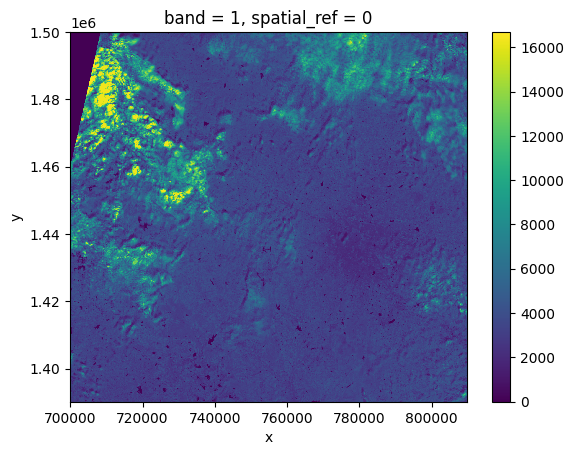

In [32]:
raster_b9.plot()

With `rioxarray`, plotting a raster becomes straightforward, with spatial coordinates automatically labeled along the x and y axes for clarity.

The visualization depicts pixel values for the spectral band `nir09` over the selected area of interest. According to Sentinel-2 documentation, this band, with a central wavelength of 945 nm, is particularly sensitive to water vapor. It has a spatial resolution of 60 meters, which, while lower than some other bands, is ideal for quick analyses and demonstrations.

It's worth noting that the `band=1` label in the image title refers to the order of bands within the `DataArray` and not specifically to the Sentinel-2 band asset `nir09`.

The image reveals high reflectance values in cloudy pixels, while other areas show lower contrast, consistent with the band’s sensitivity to water vapor. To enhance color contrast and better interpret the data, you can use the `robust=True` option, which restricts the display range to the 2nd and 98th percentiles of pixel values.

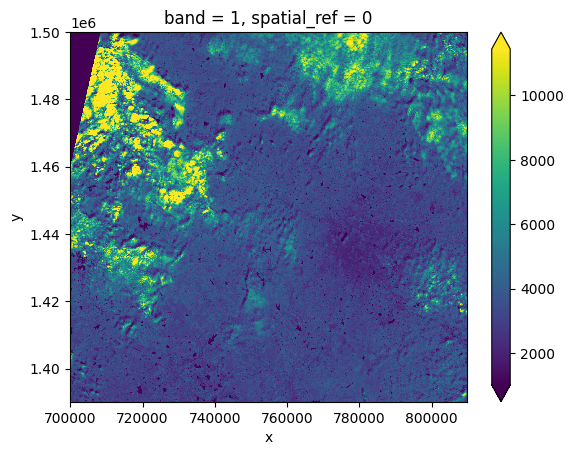

In [33]:
raster_b9.plot(robust=True)

This functionality lets you adjust the color limits to better reflect the majority of pixel values in the image. 

If the `robust=True` option doesn't provide a satisfactory representation, you can further refine the visualization by manually setting the `vmin` and `vmax` parameters. In some cases, defining a value range may produce a more tailored plot.

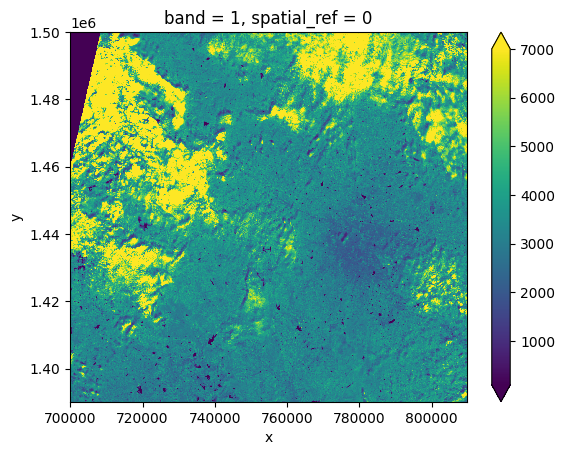

In [34]:
raster_b9.plot(vmin=100, vmax=7000)

Now, if we want to plot a subset of this image to focus more on a specific feature of interest, we can select a region of pixels again. Let's look at the internal tiling for this band of the COG:

In [35]:
print(raster_b9.shape)
tile_size = raster_b9.rio._manager.acquire().block_shapes
tile_size

(1, 1830, 1830)


[(256, 256)]

Notice that the tile size is smaller because the resolution for this band (`nir09`) is lower (60 meters) than that of the `nir` (10 meters). 

(1, 1024, 1024)


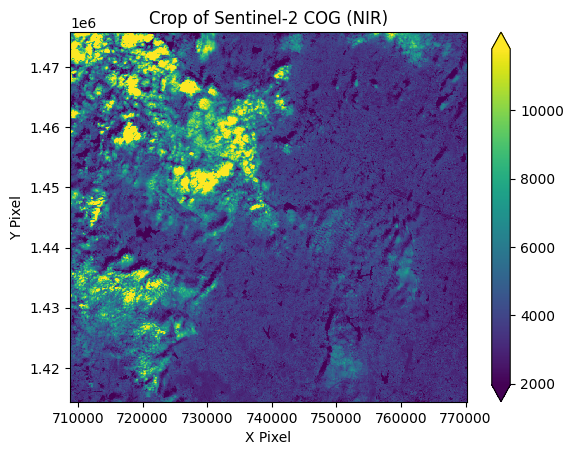

In [36]:
# Calculate the center coordinates of the image
center_x, center_y = raster_b9.sizes["x"] // 2, raster_b9.sizes["y"] // 2

# Select a crop region using .isel()
raster_b9_subset = raster_b9.isel(
    x=slice(center_x - tile_size[0][0]*3, center_x + tile_size[0][0]),
    y=slice(center_y - tile_size[0][0]*2, center_y + tile_size[0][0]*2)
)

print(raster_b9_subset.shape)

raster_b9_subset.plot(robust=True)
plt.title("Crop of Sentinel-2 COG (NIR)")
plt.xlabel("X Pixel")
plt.ylabel("Y Pixel")
plt.show()

## Deciphering the Raster Coordinate Reference System (CRS)

An essential detail to examine in geospatial data is the Coordinate Reference System (CRS), which defines how spatial data is mapped to the Earth’s surface. Using the `.rio.crs` method, you can access the CRS information of your dataset. This method retrieves the CRS string associated with your `DataArray`.

In [37]:
print(raster_b9.rio.crs)

EPSG:32643


EPSG codes are a standardized and concise way to identify specific Coordinate Reference Systems (CRS). To explore detailed information about a CRS, such as its unit of measurement, the `pyproj` library can be used. This library is designed to manage and perform operations related to CRS definitions.

In [38]:
epsg = raster_b9.rio.crs.to_epsg()
crs = CRS(epsg)
crs

<Projected CRS: EPSG:32643>
Name: WGS 84 / UTM zone 43N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°E and 78°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Maldives. Pakistan. Russian Federation. Tajikistan.
- bounds: (72.0, 0.0, 78.0, 84.0)
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The ``CRS`` class from the ``pyproj`` library enables us to create a CRS object. We can retrieve specific information about a CRS from this, as well as obtain a basic summarization of the associated CRS.

One especially valuable attribute is ``area_of_use``, which indicates the geographic boundaries for which the CRS is designed to be applied.

In [39]:
crs.area_of_use

AreaOfUse(west=72.0, south=0.0, east=78.0, north=84.0, name='Between 72°E and 78°E, northern hemisphere between equator and 84°N, onshore and offshore. China. India. Kazakhstan. Kyrgyzstan. Maldives. Pakistan. Russian Federation. Tajikistan.')

In [40]:
# More on the various attributes accessible for the CRS class can be viewed with the following:
# help(crs)

The `pyproj` CRS summary outlines all the details of a Coordinate Reference System (CRS) that Python or GIS software may utilize. For example, it describes the projection as **UTM Zone 43N**, part of the Universal Transverse Mercator (UTM) system, which divides the globe into 60 zones, each covering 6 degrees of longitude. 

This specific CRS uses the **WGS84 datum** as its reference point and applies a Cartesian coordinate system with two axes: `easting` and `northing`, measured in meters. Its geographic range spans from **72°E to 78°E** longitude and **0.0°N to 84.0°N** latitude in the northern hemisphere. 

The **Transverse Mercator** projection method is employed, optimal for regions with narrow longitudinal widths, such as UTM zones. Additionally, the CRS attributes include the mechanism for projecting coordinates onto a flat (Cartesian) plane. While the UTM system includes zones, not all CRSs are zone-specific, and this detail pertains specifically to UTM-based systems.

## Calculate Raster Statistics
Knowing basic statistical values of a raster dataset can be valuable. We can obtain some, such as minimum, maximum, mean, and standard deviation quite easily for `xarray.DataArray`s like so:

In [41]:
print(raster_b9.min())
print(raster_b9.max())
print(raster_b9.mean())
print(raster_b9.std())

<xarray.DataArray ()> Size: 2B
array(0, dtype=uint16)
Coordinates:
    spatial_ref  int64 8B 0
<xarray.DataArray ()> Size: 2B
array(16680, dtype=uint16)
Coordinates:
    spatial_ref  int64 8B 0
<xarray.DataArray ()> Size: 8B
array(4158.79998208)
Coordinates:
    spatial_ref  int64 8B 0
<xarray.DataArray ()> Size: 8B
array(2234.96163071)
Coordinates:
    spatial_ref  int64 8B 0


So with that, we can get key statistical values such as the minimum, maximum, mean, and standard deviation, along with the data type of the pixels. However, if you're interested in calculating specific quantiles, `xarray` provides the `.quantile()` method. For example, to determine the 25th and 75th percentiles, you can try the following:

In [42]:
print(raster_b9.quantile([0.25, 0.75]))

<xarray.DataArray (quantile: 2)> Size: 16B
array([3054., 4392.])
Coordinates:
  * quantile  (quantile) float64 16B 0.25 0.75


## Dealing with Missing Data

So far, we've visualized a band from a Sentinel-2 image and calculated its statistics. However, it's critical to account for missing data, often indicated by a "nodata" value in raster datasets. This special value represents pixels where no valid data is available, typically due to sensor limitations or incomplete coverage. Missing data frequently appears along the raster's edges when the dataset doesn't fully cover the analyzed region.

Raster datasets inherently have a rectangular structure, so areas without data—such as boundaries not covered by the sensor—are assigned the nodata value. For example, in this dataset, the nodata value (`raster_b9.rio.nodata`) is **0**. When visualizing the data or calculating statistics, these missing values can be mistakenly treated as valid, leading to skewed results. For instance, including nodata pixels with a value of zero could lower the 25th percentile or other metrics inaccurately.

To handle this, missing data can be represented as `NaN` (Not a Number), which ensures it is excluded from calculations. This transformation can be achieved by setting the parameter `masked=True` when loading the raster dataset. This approach provides a clearer distinction between valid and missing data, preventing distortion in analyses or visualizations.

In [43]:
raster_b9 = rioxarray.open_rasterio(s2_items[0].assets["nir09"].href, masked=True)

You can also utilize the `where` function to filter out all the pixels that differ from the raster's `nodata` value:

In [44]:
raster_b9.where(raster_b9!=raster_b9.rio.nodata)

<xarray.DataArray (band: 1, y: 1830, x: 1830)> Size: 13MB
array([[[  nan,   nan,   nan, ..., 2394., 2983., 3095.],
        [  nan,   nan,   nan, ..., 2063., 1998., 2116.],
        [  nan,   nan,   nan, ..., 2256., 1974., 2850.],
        ...,
        [3068., 3056., 2905., ..., 3726., 4071., 4567.],
        [3081., 2932., 3007., ..., 2569., 2852., 3336.],
        [3065., 3190., 3043., ..., 2229., 2144., 2484.]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 15kB 7e+05 7e+05 7.001e+05 ... 8.097e+05 8.097e+05
  * y            (y) float64 15kB 1.5e+06 1.5e+06 1.5e+06 ... 1.39e+06 1.39e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    scale_factor:        1.0
    add_offset:          0.0

Both approaches will replace the nodata value of **0** with `NaN`, allowing missing data to be excluded from calculations. This ensures that recalculated statistics are accurate, as the nodata pixels are no longer treated as valid data points. 

By the way, a tip for a cleaner output: you can use the `.values` attribute when applying statistical functions. This returns only the computed values, without including any of the object metadata associated with the raster dataset. This streamlined result is particularly useful for further numerical analysis or visualization, as it provides just the values without the metadata.

In [45]:
print(raster_b9.min().values)
print(raster_b9.max().values)
print(raster_b9.mean().values)
print(raster_b9.std().values)

1.0
16680.0
4215.6777
2196.2656


It's worth mentioning that replacing `0` with `nan` to represent missing data will cause a change in the data type of the `DataArray` from integers to floats. This is an important consideration if the data type plays a crucial role in your specific use case or application.

## Incorporating multiple bands 

Up to now, we have worked with single-band rasters, focusing on the `nir` and later the `nir09` bands from a Sentinel-2 scene. To obtain a more easy-to-interpret RGB "true-color" depiction of the area, we can utilize the True Color Image (TCI) asset. This asset provides a high-resolution visualization by combining three optical bands—Red, Green, and Blue (RGB)—captured by the Sentinel-2 satellite’s MultiSpectral Instrument (MSI). With a spatial resolution of 10 meters, the TCI functions as a clear and detailed view of the area, making it ideal for quick visual assessments and analysis. Like the `nir09` band, we can load the TCI using:

In [46]:
raster_overview = rioxarray.open_rasterio(s2_items[0].assets['visual'].href, overview_level=3)
raster_overview

<xarray.DataArray (band: 3, y: 687, x: 687)> Size: 1MB
[1415907 values with dtype=uint8]
Coordinates:
  * band         (band) int64 24B 1 2 3
  * x            (x) float64 5kB 7e+05 7.002e+05 ... 8.095e+05 8.097e+05
  * y            (y) float64 5kB 1.5e+06 1.5e+06 1.5e+06 ... 1.39e+06 1.39e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

We specified the argument `overview_level=3`, which corresponds to the spatial resolution determined by the level of downsampling in Sentinel-2 COGs. The native spatial resolution for Sentinel-2's True Color Image (TCI) bands is 10 meters. However, each overview level reduces this resolution by a factor of 2.

The resolution at different overview levels is as follows:
- Level 0 (native): 10 meters
- Level 1: 20 meters
- Level 2: 40 meters
- Level 3: 80 meters

When loading GeoTIFFs with the `open_rasterio()` function and checking the shape, the band dimension will appear first. For instance, in the `xarray.DataArray` object, the shape would be `(band: 3, y: 687, x: 687)`, showing three bands. It's always a good idea to inspect the shape of the raster array both after loading it and during any data manipulations (such as calculating band ratios or warping). This is especially important since many functions, particularly those for image plotting, expect the raster to have a specific shape (e.g., 1 or 3 channels arranged in a certain order). You can easily verify the shape using the `.shape` attribute.

In [47]:
raster_overview.shape

(3, 687, 687)

You can visualize the multi-band data using the `DataArray.plot.imshow()` function:

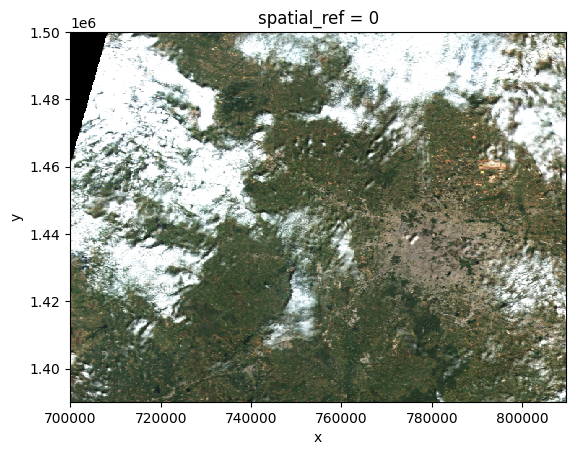

In [48]:
raster_overview.plot.imshow()

Keep in mind that the `DataArray.plot.imshow()` function is designed to work with image arrays that have three channels, which corresponds to the RGB color model. It is not suitable for arrays containing more than three channels. However, you can create a false-color image by using different channels in place of the typical RGB.

As shown in the previous figure, the true-color image may appear stretched. To correct the aspect ratio, you can adjust the settings in `DataArray.plot.imshow()`. Since the height-to-width ratio is 1:1 (verified by the `rio.height` and `rio.width` attributes), it's best to set the aspect ratio to 1. For example, you might choose to set the plot size to 5 inches and specify `aspect=1`. Keep in mind that when using the `aspect` argument, you must also define the plot size, as indicated in the `DataArray.plot.imshow()` documentation.

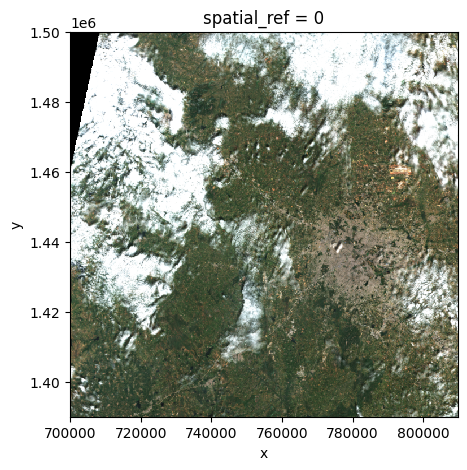

In [49]:
raster_overview.plot.imshow(size=5, aspect=1)

Now, let's consider working not only with visual bands but also with other bands like the `nir` band. We'll introduce a new tool called [Open Data Cube (ODC)](https://www.opendatacube.org/), which we imported as `odc`, to help load multi-spectral time series raster data from STAC into an `xarray.Dataset`. The `odc` library provides an extension for handling raster data from STAC-compliant catalogs. We'll use this to more efficiently manage the Sentinel-2 data we previously queried.

In the following cell, the process is as follows:

1. **`s2_data = odc.stac.load(...)`**:
   - This loads the actual raster data from the Sentinel-2 items we retrieved earlier. The `load` function from `odc` fetches the data associated with the metadata.

2. **`items=s2_items`**:
   - Here, `s2_items` represents the Sentinel-2 scenes we collected from the STAC catalog, which contain the metadata and location information.

3. **`bands=["red", "green", "blue", "nir", "scl"]`**:
   - This specifies the spectral bands to load, including Red, Green, Blue, Near-Infrared (NIR), and the Scene Classification Layer (SCL), which helps identify cloudy pixels.

4. **`bbox=box_coords`**:
   - The `bbox` argument defines the **Area of Interest (AOI)** by specifying the geographic bounding box using coordinates in the format `[min_longitude, min_latitude, max_longitude, max_latitude]`, which corresponds to the region we are interested in.

5. **`progress=tqdm`**:
   - The `progress` argument integrates `tqdm`, a library that shows a progress bar, helping track the loading process, especially when dealing with large datasets.

**IMPORTANT:**
When the `bbox` argument is provided, `odc` will automatically clip the raster data to match the bounding box. This ensures that only the relevant data for the specified region is returned.

The resulting `s2_data` is an `xarray.Dataset` that we can use for further analysis.

In [50]:
s2_data = odc.stac.load(
    items=s2_items[:12],
    bands=["red", "green", "blue", "nir", "scl"],
    bbox=bbox_coords,
    progress=tqdm,
    chunks={'x': 1024, 'y': 1024, 'time': -1},
)

The `odc.stac.load()` function returns an `xarray.Dataset` instead of an `xarray.DataArray` because we are loading multiple spectral bands (e.g., "red", "green", "blue", "nir", "scl"). An `xarray.Dataset` is used to store multiple variables, or bands, each represented as a `DataArray`. A `DataArray` typically holds a single variable (e.g. band) along with its associated dimensions and coordinates. Since we are loading more than one band, the function returns a `Dataset`, which is essentially a collection of `DataArrays`, each corresponding to one of the requested bands.

The `xarray.Dataset` structure allows you to work with related variables (e.g., spectral bands) that share common coordinates, such as latitude, longitude, and time. This structure is particularly useful when performing operations that involve multiple bands, like creating a composite RGB image or conducting multi-band analyses. 

If you were only loading a single band, the function would return a `DataArray`, which is more suited to handling one variable. However, since multiple bands are requested, a `Dataset` is the appropriate return type.

In [51]:
s2_data

<xarray.Dataset> Size: 318MB
Dimensions:      (y: 2970, x: 3964, time: 3)
Coordinates:
  * y            (y) float64 24kB 1.438e+06 1.438e+06 ... 1.409e+06 1.409e+06
  * x            (x) float64 32kB 7.523e+05 7.523e+05 ... 7.919e+05 7.919e+05
    spatial_ref  int32 4B 32643
  * time         (time) datetime64[ns] 24B 2020-07-12T05:25:21.422000 ... 202...
Data variables:
    red          (time, y, x) uint16 71MB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 71MB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>
    blue         (time, y, x) uint16 71MB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>
    nir          (time, y, x) uint16 71MB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>
    scl          (time, y, x) uint8 35MB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>

Notice that the time dimension is automatically interpreted and aligned with the number of items returned from `s2_search.matched()` and `len(s2_items)` earlier. This means that the dataset now contains multiple Sentinel-2 images, each corresponding to different timestamps and overlapping the area of interest (AOI). By default, `odc` stacks these images in a time series, without assuming any manipulation is required on the time dimension.

To visualize the dataset, we can composite the images over time, reducing the temporal dimension to a single layer where each pixel represents the average of all available timestamps. This approach gives us a temporal depth of 1, providing a composite that reflects changes over time, simplifying the data for easier interpretation.

In [52]:
s2_data_composite = s2_data.mean(dim='time')

Notice the new shape of the dataset:

In [53]:
s2_data_composite

<xarray.Dataset> Size: 471MB
Dimensions:      (y: 2970, x: 3964)
Coordinates:
  * y            (y) float64 24kB 1.438e+06 1.438e+06 ... 1.409e+06 1.409e+06
  * x            (x) float64 32kB 7.523e+05 7.523e+05 ... 7.919e+05 7.919e+05
    spatial_ref  int32 4B 32643
Data variables:
    red          (y, x) float64 94MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    green        (y, x) float64 94MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    blue         (y, x) float64 94MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    nir          (y, x) float64 94MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    scl          (y, x) float64 94MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>

Also notice here that the aspect ratio is not perfectly 1:1, so let's compute the correct aspect ratio to use when plotting. We can plot a true color image from the dataset by specifying the necessary bands.

In [54]:
aspect_ratio_composite = s2_data_composite.x.shape[0] / s2_data_composite.y.shape[0]

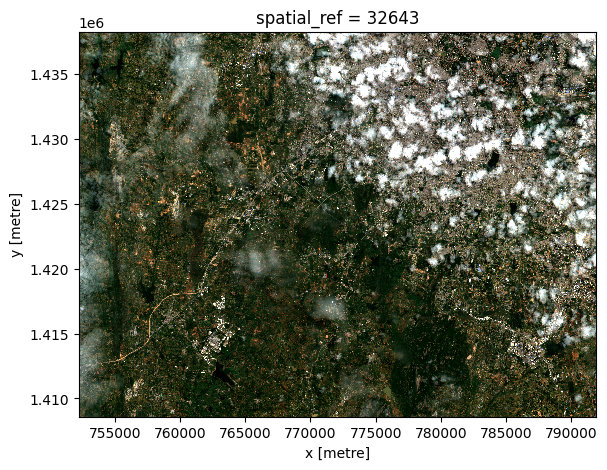

/Users/lillythomas/Documents/work/clay/lt/servir/model/docs/tutorials/ingarss/lib/python3.12/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [55]:
s2_data_composite[["red", "green", "blue"]].to_array("band").plot.imshow(rgb="band", robust=True, size=5, aspect=aspect_ratio_composite)

We can also plot any single band from the dataset like so:

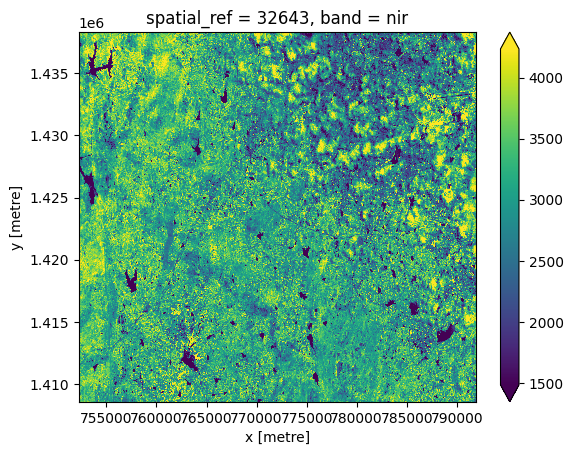

In [56]:
s2_data_composite[["nir"]].to_array("band").plot(robust=True)

Let's say we want to take a look at the time series for a single band. We can do this by taking the average in the spatial dimensions (x and y) for each timestamp and plotting the values.

In [57]:
s2_data_mean_time_series = s2_data.mean(dim=["y", "x"])

Then we can extract the time series for one of bands. Near infrared is interesting because it is useful in determing seasonal phenology.

In [58]:
nir_time_series = s2_data_mean_time_series["nir"]

We can plot a line plot for the near infrared averages for each timestamp.

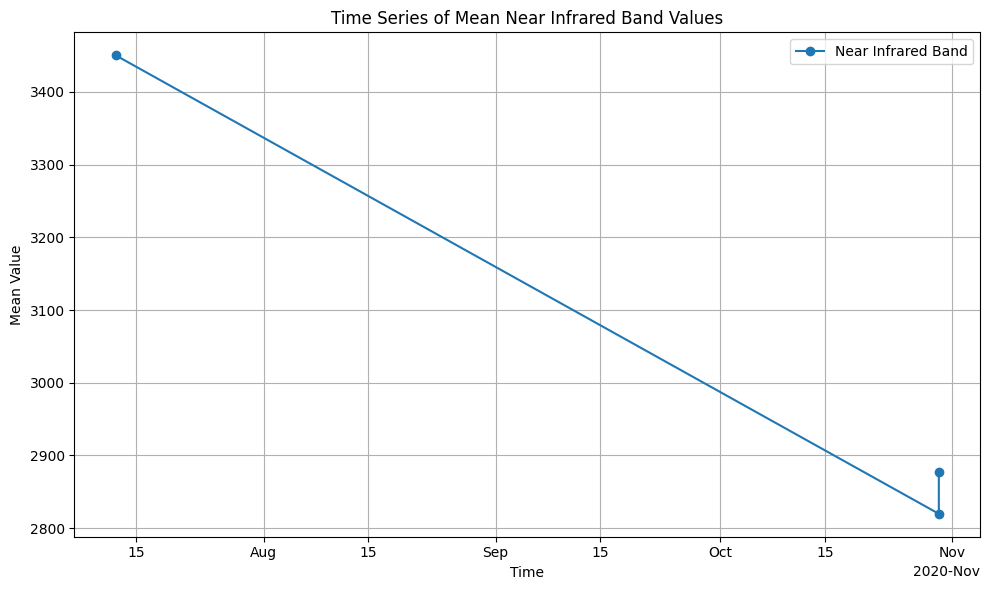

In [59]:
plt.figure(figsize=(10, 6))
nir_time_series.plot(label='Near Infrared Band', marker='o')

plt.title("Time Series of Mean Near Infrared Band Values")
plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Dealing with cloud-covered and invalid pixels

To mask out clouds and invalid pixels from Sentinel-2 data, we can use the 'SCL' (Scene Classification Layer) band, which includes cloud and no data information. The SCL band classifies each pixel in the Sentinel-2 image, including cloud-related classes such as cloud shadows, medium-probability clouds, high-probability clouds, and cirrus clouds. By masking out these classes as well as those with the no data value, we can ignore unwanted pixels in the dataset.

First we need to declare the cloud-related SCL classes. The common classes for clouds are:

> Cloud Shadows: 3
>
> Low probability clouds: 7
>
> Medium probability clouds: 8
> 
> High probability clouds: 9
> 
> Thin cirrus: 10

In order to mask out these cloud classes, we'll create a boolean mask using `xarray`'s `.isin()` method. We will use these masks to filter out cloud-covered and invalid pixels in the red, green, blue, and NIR bands.

In [60]:
cloud_classes = [3, 7, 8, 9, 10]  # Cloud-related SCL classes
cloud_mask = s2_data['scl'].isin(cloud_classes)
masked_s2_data = s2_data[['red', 'green', 'blue', 'nir']].where(~cloud_mask, drop=False)  # Keep all pixels

We will do the same for the no data "class."

In [61]:
nodata_value =  s2_data['scl'].nodata
nodata_mask = s2_data['scl'].isin(nodata_value)
masked_s2_data = masked_s2_data[['red', 'green', 'blue', 'nir']].where(~nodata_value, drop=False)

In [62]:
masked_s2_data

<xarray.Dataset> Size: 565MB
Dimensions:      (time: 3, y: 2970, x: 3964)
Coordinates:
  * y            (y) float64 24kB 1.438e+06 1.438e+06 ... 1.409e+06 1.409e+06
  * x            (x) float64 32kB 7.523e+05 7.523e+05 ... 7.919e+05 7.919e+05
    spatial_ref  int32 4B 32643
  * time         (time) datetime64[ns] 24B 2020-07-12T05:25:21.422000 ... 202...
Data variables:
    red          (time, y, x) float32 141MB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) float32 141MB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>
    blue         (time, y, x) float32 141MB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>
    nir          (time, y, x) float32 141MB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>

Let's examine the masked data to verify the results. To do this, let's composite the imagery again to get a temporal average.

In [63]:
masked_s2_data_composite = masked_s2_data.mean(dim='time')

In [64]:
masked_s2_data_composite

<xarray.Dataset> Size: 188MB
Dimensions:      (y: 2970, x: 3964)
Coordinates:
  * y            (y) float64 24kB 1.438e+06 1.438e+06 ... 1.409e+06 1.409e+06
  * x            (x) float64 32kB 7.523e+05 7.523e+05 ... 7.919e+05 7.919e+05
    spatial_ref  int32 4B 32643
Data variables:
    red          (y, x) float32 47MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    green        (y, x) float32 47MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    blue         (y, x) float32 47MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    nir          (y, x) float32 47MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>

Now we can plot an image.

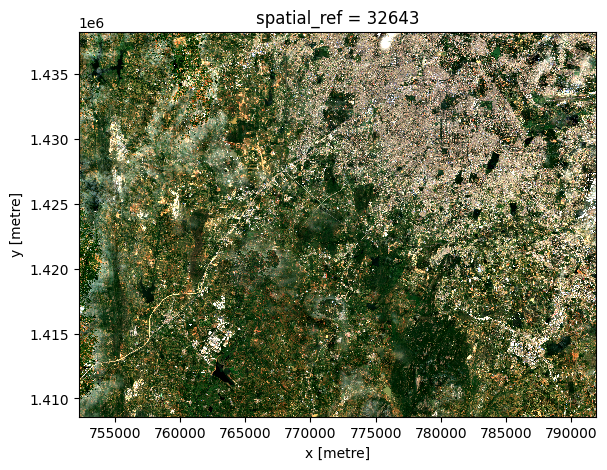

In [65]:
masked_s2_data_composite[['red', 'green', 'blue']].to_array("band").plot.imshow(rgb="band", robust=True, size=5, aspect=aspect_ratio_composite)

The image plot is looking a bit over-exposed. Let's adjust the value ranges to better fit the raster data.

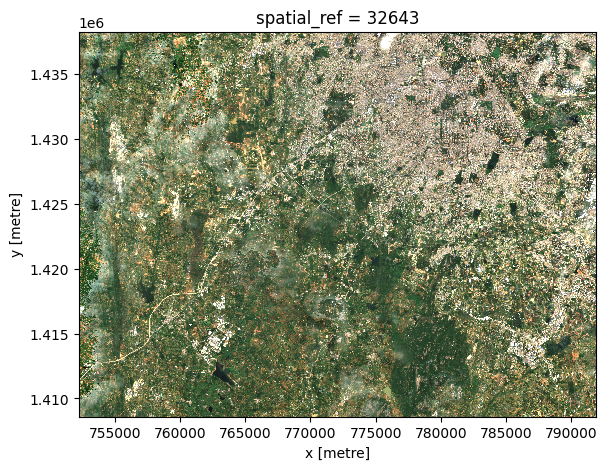

In [66]:
masked_s2_data_composite[['red', 'green', 'blue']].to_array("band").plot.imshow(rgb="band", robust=True, size=5, aspect=aspect_ratio_composite, vmin=0, vmax=2000)

That looks pretty good! Now we have a cloud-masked composite. We can use this to get a clearer signal of near infrared over time.

## Calculate a spectral index

In this next section, we will use our masked multi-spectral data to calculate a relevant spectral index for tasks such as crop type classification.

**NDVI (Normalized Difference Vegetation Index)** is a widely used index to assess vegetation health and density. It quantifies the difference between near-infrared (NIR) light, which vegetation strongly reflects, and red light, which vegetation absorbs. Higher NDVI values typically indicate healthier or denser vegetation, while lower or negative values suggest sparse or no vegetation (e.g., bare soil, urban areas, or water).

In [67]:
masked_s2_ndvi = (masked_s2_data["nir"] - masked_s2_data["red"]) / (masked_s2_data["nir"] + masked_s2_data["red"])

Now let's make a time series again and plot it.

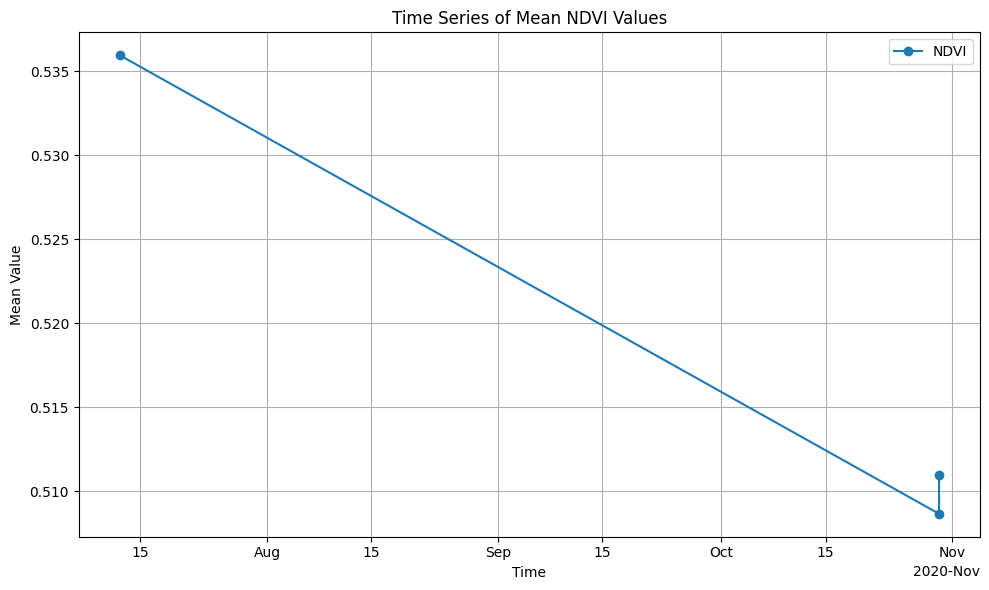

In [68]:
masked_s2_ndvi_mean_time_series = masked_s2_ndvi.mean(dim=["y", "x"])
plt.figure(figsize=(10, 6))
masked_s2_ndvi_mean_time_series.plot(label='NDVI', marker='o')

plt.title("Time Series of Mean NDVI Values")
plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The dataset titled **"10,000 Crop Field Boundaries across India"** (by Wang et al., 2022) contains manually delineated boundaries of 10,000 crop fields across India, created through the analysis of high-resolution satellite imagery from Airbus SPOT. The dataset is specifically designed to support research and applications in crop field mapping and agricultural monitoring, particularly in smallholder farming systems.

This dataset aims to advance methods for identifying and analyzing crop fields at scale, enabling better understanding and management of smallholder farming landscapes. For further details and access to the dataset and model weights, visit the [Zenodo record](https://zenodo.org/record/7315090).

We will use this dataset to demonstrate scalably vector dataset visualization with Lonboard and then subsquently compute zonal statistics using the polygons, our subdistrict and a NDVI raster.

Let's start by reading in the shapefile.

In [70]:
field_boundaries_india = gpd.read_file("./7315090/india_10k_fields.shp")

In [71]:
field_boundaries_india

area  sample                                           geometry
0      9620.550048       0  POLYGON ((73.10624 26.30254, 73.10624 26.30257...
1      5244.485268       0  POLYGON ((73.10746 26.3016, 73.10746 26.30162,...
2      1983.845942       0  POLYGON ((73.10792 26.3012, 73.10792 26.30122,...
3      5191.243054       0  POLYGON ((73.10543 26.29889, 73.10543 26.29893...
4      5728.435942       0  POLYGON ((73.10319 26.29923, 73.10325 26.29923...
...            ...     ...                                                ...
10008   753.823903    2002  POLYGON ((91.4845 26.62626, 91.4845 26.62631, ...
10009  2500.742071    2002  POLYGON ((91.48521 26.62618, 91.48523 26.62618...
10010  2002.759594    2002  POLYGON ((91.48453 26.62572, 91.48453 26.62577...
10011  4013.147174    2002  POLYGON ((91.48544 26.625, 91.48544 26.62508, ...
10012   456.357790    2002  POLYGON ((91.48611 26.62491, 91.48611 26.62495...

[10013 rows x 3 columns]

And then visualize it:

In [72]:
layer = PolygonLayer.from_geopandas(
    field_boundaries_india,
    get_line_width=20,  # width in default units (meters)
    line_width_min_pixels=0.2,  # minimum width when zoomed out
    get_fill_color=[255, 0, 0],  # red
    get_line_color=[37, 36, 34],  # dark border color
)

In [73]:
m = Map(layer)
m

Map(custom_attribution='', layers=(PolygonLayer(get_fill_color=[255, 0, 0], get_line_color=[37, 36, 34], get_l…

Now let's get all of the field boundaries within the AOI we've been focusing on.

In [74]:
scene_geom = gpd.GeoDataFrame({'geometry': [shape(item.geometry)]}, crs="EPSG:4326")

In [75]:
clipped_field_boundaries_india = field_boundaries_india.to_crs(epsg=4326).clip(scene_geom)

In [76]:
len(clipped_field_boundaries_india)

40

Let's visualize the clipped results:

In [77]:
layer = PolygonLayer.from_geopandas(
    clipped_field_boundaries_india,
    get_line_width=20,  # width in default units (meters)
    line_width_min_pixels=0.2,  # minimum width when zoomed out
    get_fill_color=[255, 0, 0],  # red
    get_line_color=[37, 36, 34],  # dark border color
)

m = Map(layer)
m

Map(custom_attribution='', layers=(PolygonLayer(get_fill_color=[255, 0, 0], get_line_color=[37, 36, 34], get_l…

## Zonal statistics
We will calculate **zonal statistics** now for an NDVI composite. Zonal statistics refers to the computation of summary statistics (e.g., mean, sum, min, max) for raster data within the zones defined by vector geometries. This is a common task in spatial analysis for aggregating raster values over regions. We will use a Python library called `GeoCube` to convert vector data (e.g., GeoDataFrames) into rasterized datasets. It allows rasterization while aligning with a reference grid (such as Sentinel-2 data). Its common use case is generating gridded representations of vector data to perform spatial analyses like zonal statistics.

We will use GeoCube to generate summary level zonal statistics and the older library, `rasterstats` to compute polygon level zonal statistics.

Let's start by creating a numerical class for the polygons. For this, all polygons are simply foreground, so wet set the class for all to 1.

In [78]:
clipped_field_boundaries_india["numerical_class"] = 1

In [79]:
clipped_field_boundaries_india.head(10)

area  sample                                           geometry  \
139   452.008538      27  POLYGON ((77.19555 13.00995, 77.19557 13.00995...   
138   468.519884      27  POLYGON ((77.19539 13.01004, 77.1954 13.01004,...   
136   381.477574      27  POLYGON ((77.1955 13.01044, 77.19556 13.01044,...   
137   449.036190      27  POLYGON ((77.19532 13.01038, 77.19533 13.01038...   
135   559.956668      27  POLYGON ((77.19529 13.01065, 77.19531 13.01065...   
524  3220.019947     104  POLYGON ((77.77795 12.67281, 77.77797 12.67281...   
523  2333.354229     104  POLYGON ((77.77656 12.67305, 77.77658 12.67305...   
522  2175.137974     104  POLYGON ((77.77683 12.67553, 77.77684 12.67553...   
521  6876.249467     104  POLYGON ((77.7783 12.67625, 77.77841 12.67625,...   
520  1781.159808     104  POLYGON ((77.78231 12.67702, 77.78232 12.67702...   

     numerical_class  
139                1  
138                1  
136                1  
137                1  
135                1  
524                1  
523                1  
522                1  
521                1  
520                1

Now let's get the correct data for this extent, again chunking the data with dask for faster computation.

In [80]:
s2_data = odc.stac.load(
    items=s2_items,
    bands=["red", "green", "blue", "nir", "scl"],
    bbox=clipped_field_boundaries_india.total_bounds,
    chunks={'x': 1024, 'y': 1024, 'time': -1},
    epsg=4326,
    progress=tqdm,
)

Now let's create a rasterized version of the field boundaries.

In [81]:
# Define the resolution and bounds based on Sentinel-2 data
resolution = s2_data.rio.resolution()
bounds = s2_data.rio.bounds()

# Rasterize the vector dataset to match Sentinel-2
rasterized_field_boundaries = make_geocube(
    vector_data=clipped_field_boundaries_india,
    measurements=["numerical_class"], 
    like=s2_data,  # Align with the features dataset
)

# The rasterized output is an xarray.Dataset
print(np.unique(rasterized_field_boundaries["numerical_class"].values))

[ 1. nan]


We can see there are `nan` values that we need to remove. Let's replace those with zero.

In [82]:
rasterized_field_boundaries = rasterized_field_boundaries.where(~np.isnan(rasterized_field_boundaries), other=0)  # Replace NaNs with 0 (or another value of your choice)

In [83]:
print(np.unique(rasterized_field_boundaries["numerical_class"].values))

[0. 1.]


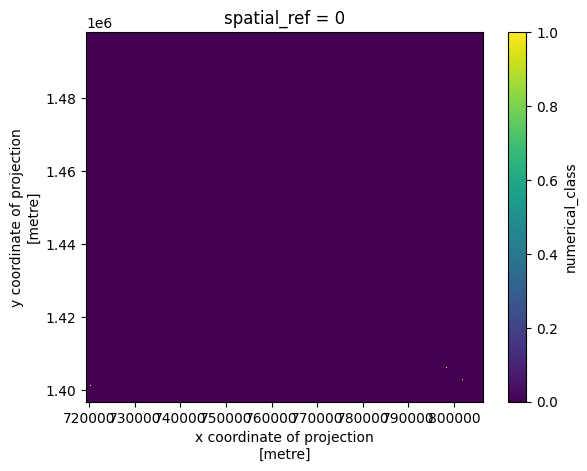

In [84]:
rasterized_field_boundaries["numerical_class"].plot()

Get the cloud and no data masks.

In [85]:
cloud_mask = s2_data['scl'].isin(cloud_classes)
nodata_value =  s2_data['scl'].nodata
nodata_mask = s2_data['scl'].isin(nodata_value)

Mask the non-SCL bands.

In [86]:
nodata_masked_s2_data = s2_data[['red', 'green', 'blue', 'nir']].where(~nodata_value, drop=False)  # Keep all pixels
cloud_masked_s2_data = nodata_masked_s2_data[['red', 'green', 'blue', 'nir']].where(~cloud_mask, drop=False)  # Keep all pixels
masked_s2_data = cloud_masked_s2_data.copy()

Calculate NDVI for this new Sentinel-2 raster.

In [87]:
masked_s2_ndvi = (masked_s2_data["nir"] - masked_s2_data["red"]) / (masked_s2_data["nir"] + masked_s2_data["red"])

masked_s2_ndvi_composite = masked_s2_ndvi.mean(dim=["time"])

In [88]:
masked_s2_data

<xarray.Dataset> Size: 4GB
Dimensions:      (time: 3, y: 10111, x: 8699)
Coordinates:
  * y            (y) float64 81kB 1.498e+06 1.498e+06 ... 1.397e+06 1.397e+06
  * x            (x) float64 70kB 7.194e+05 7.194e+05 ... 8.064e+05 8.064e+05
    spatial_ref  int32 4B 32643
  * time         (time) datetime64[ns] 24B 2020-07-12T05:25:21.422000 ... 202...
Data variables:
    red          (time, y, x) float32 1GB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) float32 1GB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>
    blue         (time, y, x) float32 1GB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>
    nir          (time, y, x) float32 1GB dask.array<chunksize=(3, 1024, 1024), meta=np.ndarray>

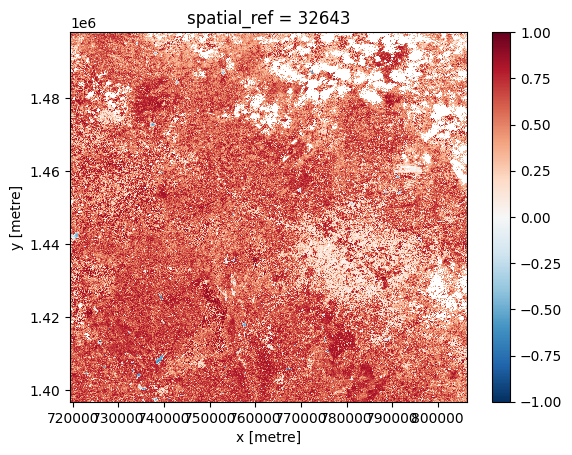

In [103]:
masked_s2_ndvi_composite.plot()

Let's chunk again to optimize handling of the raster datasets.

In [89]:
masked_s2_ndvi_composite = masked_s2_ndvi_composite.chunk({'x': 1024, 'y': 1024})
rasterized_field_boundaries = rasterized_field_boundaries.chunk({'x': 1024, 'y': 1024})

Combine the NDVI and field boundareis rasters.

In [90]:
rasterized_field_boundaries["ndvi"] = (masked_s2_ndvi_composite.dims, masked_s2_ndvi_composite.values, masked_s2_ndvi_composite.attrs, masked_s2_ndvi_composite.encoding)

In [91]:
rasterized_field_boundaries

<xarray.Dataset> Size: 1GB
Dimensions:          (y: 10111, x: 8699)
Coordinates:
  * y                (y) float64 81kB 1.498e+06 1.498e+06 ... 1.397e+06
  * x                (x) float64 70kB 7.194e+05 7.194e+05 ... 8.064e+05
    spatial_ref      int64 8B 0
Data variables:
    numerical_class  (y, x) float64 704MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    ndvi             (y, x) float32 352MB 0.418 0.3964 0.3867 ... 0.6068 0.6541

Now let's get the aggregate zonal statistics for the field boundaries.

In [93]:
rasterized_field_boundaries_ = rasterized_field_boundaries.drop("spatial_ref").groupby(rasterized_field_boundaries.numerical_class)

In [94]:
field_boundaries_india_clipped_ndvi_mean = rasterized_field_boundaries_.mean().rename({"ndvi": "ndvi_mean"})
field_boundaries_india_clipped_ndvi_min = rasterized_field_boundaries_.min().rename({"ndvi": "ndvi_min"})
field_boundaries_india_clipped_ndvi_max = rasterized_field_boundaries_.max().rename({"ndvi": "ndvi_max"})
field_boundaries_india_clipped_ndvi_std = rasterized_field_boundaries_.std().rename({"ndvi": "ndvi_std"})

In [95]:
field_boundaries_india_clipped_ndvi_mean.values

<bound method Mapping.values of <xarray.Dataset> Size: 24B
Dimensions:          (numerical_class: 2)
Coordinates:
  * numerical_class  (numerical_class) float64 16B 0.0 1.0
Data variables:
    ndvi_mean        (numerical_class) float32 8B 0.5307 0.4909>

In [98]:
zonal_stats_ndvi = xr.merge([field_boundaries_india_clipped_ndvi_mean, field_boundaries_india_clipped_ndvi_min, field_boundaries_india_clipped_ndvi_max, field_boundaries_india_clipped_ndvi_std]).to_dataframe()
zonal_stats_ndvi

ndvi_mean  ndvi_min  ndvi_max  ndvi_std
numerical_class                                         
0.0               0.530743 -1.000000  1.000000  0.200228
1.0               0.490864  0.085095  0.804157  0.167253

Now let's calculate non-aggregated (per field boundary polygon) basic statistics for NDVI.

In [100]:
# Calculate zonal stats
zonal_stats_ndvi = zonal_stats(
    clipped_field_boundaries_india.to_crs(epsg=32643),
    masked_s2_ndvi_composite.values,
    affine=masked_s2_ndvi_composite.rio.transform(),
    stats=["mean", "min", "max", "sum"],
    geojson_out=True
)

# Convert the results back to a GeoDataFrame
zonal_stats_ndvi_gdf = gpd.GeoDataFrame.from_features(zonal_stats_ndvi)

In [102]:
zonal_stats_ndvi_gdf

geometry         area  sample  \
0   POLYGON ((738131.85 1439263.932, 738133.306 14...   452.008538      27   
1   POLYGON ((738113.871 1439273.154, 738115.318 1...   468.519884      27   
2   POLYGON ((738125.574 1439318.164, 738131.871 1...   381.477574      27   
3   POLYGON ((738106.283 1439310.597, 738107.74 14...   449.036190      27   
4   POLYGON ((738103.12 1439340.673, 738104.577 14...   559.956668      27   
5   POLYGON ((801742.521 1402559.627, 801743.973 1...  3220.019947     104   
6   POLYGON ((801591.023 1402583.684, 801592.474 1...  2333.354229     104   
7   POLYGON ((801616.689 1402859.442, 801618.141 1...  2175.137974     104   
8   POLYGON ((801775.796 1402940.613, 801787.428 1...  6876.249467     104   
9   POLYGON ((802210.612 1403030.66, 802212.073 14...  1781.159808     104   
10  POLYGON ((806200.341 1404669.145, 806201.792 1...  1333.233897      90   
11  POLYGON ((806232.949 1404657.152, 806234.4 140...  4836.028260      90   
12  POLYGON ((806179.139 1404747.409, 806180.59 14...  1799.699851      90   
13  POLYGON ((806204.809 1404793.608, 806206.27 14...   764.365011      90   
14  POLYGON ((806253.869 1404784.752, 806255.803 1...  1982.638401      90   
15  POLYGON ((798346.648 1406216.364, 798348.1 140...  3447.764752     950   
16  POLYGON ((797915.932 1406385.597, 797917.384 1...   750.264877     950   
17  POLYGON ((797959.583 1406382.601, 797961.035 1...  1771.659656     950   
18  POLYGON ((797939.972 1406403.619, 797941.424 1...  2019.944969     950   
19  POLYGON ((797932.323 1406439.583, 797933.775 1...  1067.775269     950   
20  POLYGON ((768371.235 1397348.625, 768405.651 1...  1025.247142    1388   
21  POLYGON ((768407.266 1397383.023, 768428.11 13...   721.308522    1388   
22  POLYGON ((768452.332 1397384.436, 768474.623 1...   714.963976    1388   
23  POLYGON ((768377.216 1397383.23, 768405.81 139...   948.333312    1388   
24  POLYGON ((768429.552 1397384.71, 768450.877 13...   725.152333    1388   
25  POLYGON ((764659.755 1497406.653, 764661.205 1...  4514.587506     302   
26  POLYGON ((764613.318 1497414.58, 764614.774 14...  6055.582627     302   
27  POLYGON ((764734.893 1497523.894, 764736.344 1...  1347.293092     302   
28  POLYGON ((764697.161 1497529.933, 764698.612 1...  1132.023878     302   
29  POLYGON ((764620.928 1497571.623, 764632.514 1...  3427.200102     302   
30  POLYGON ((729241.019 1420568.793, 729242.468 1...   503.241460    1071   
31  POLYGON ((729245.706 1420586.596, 729247.165 1...   471.225105    1071   
32  POLYGON ((729268.398 1420595.67, 729269.847 14...   185.511319    1071   
33  POLYGON ((729250.427 1420601.441, 729251.886 1...   238.424294    1071   
34  POLYGON ((729257.554 1420618.273, 729259.012 1...   520.434613    1071   
35  POLYGON ((720211.65 1401183.399, 720213.111 14...  3448.199831    1628   
36  POLYGON ((720187.523 1401233.049, 720188.984 1...  7783.891636    1628   
37  POLYGON ((720205.462 1401294.376, 720206.913 1...  6218.653945    1628   
38  POLYGON ((720397.629 1401317.084, 720399.079 1...  1628.083581    1628   
39  POLYGON ((720410.962 1401346.794, 720412.413 1...  2808.739045    1628   

    numerical_class       min       max      mean        sum  
0                 1  0.692072  0.702829  0.697427   2.789707  
1                 1  0.679882  0.700590  0.689284   2.757134  
2                 1  0.615271  0.638046  0.626659   1.253317  
3                 1  0.567802  0.620025  0.587040   1.761121  
4                 1  0.543801  0.650316  0.579324   2.896618  
5                 1  0.237503  0.507128  0.341500  10.927989  
6                 1  0.168565  0.546557  0.381363   9.534066  
7                 1  0.264473  0.348570  0.305190   6.408987  
8                 1  0.085095  0.475538  0.310364  21.104778  
9                 1  0.408417  0.525182  0.487527   8.287964  
10                1  0.547016  0.683138  0.626002   8.764026  
11                1  0.431082  0.624055  0.561027  26.368275  
12                1  0.3577